In [13]:
from functions import intodf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage import generic_filter

### Load data

In [2]:
df3 = intodf('O013257.npz') #image3 - test
df2 = intodf('O013490.npz') #image2 - train
df1 = intodf('O012791.npz') #image1 - train

# Drop label=0 since they are of no use.
df1 = df1[df1['label'] != 0]
df2 = df2[df2['label'] != 0]
df3 = df3[df3['label'] != 0]

In [3]:
# Define features and labels for each
X_df1 = df1.drop(columns=["X", "Y", "label"])
y_df1 = df1["label"]
X_df2 = df2.drop(columns=["X", "Y", "label"])
y_df2 = df2["label"]
X_test = df3.drop(columns=["X", "Y", "label"])
y_test = df3["label"]

# Full training set for final retraining
df_train = pd.concat([df1, df2])
X_train_full = df_train.drop(columns=["X", "Y", "label"])
y_train_full = df_train["label"]

### XGboost

In [4]:
# Hyperparameter grid for XGBoost
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.15]
}

# Base parameters for XGBoost
base_params = {
    'objective': 'binary:logistic',  # binary classification
    'eval_metric': 'error',          # Error = 1 - accuracy
    'colsample_bytree': 0.7,         # 
    'subsample': 0.8,                # 
    'verbosity': 0                   # Silence XGBoost output
}

###### 2-Fold CV setup #######
folds = [
    (X_df1, y_df1, X_df2, y_df2),  # Train on df1, validate on df2
    (X_df2, y_df2, X_df1, y_df1)   # Train on df2, validate on df1
]

# Hyperparameter tuning: grid search over the 9 parameter combinations
best_params = None
best_avg_val_error = float('inf')

for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        params = base_params.copy()
        params['max_depth'] = max_depth
        params['learning_rate'] = learning_rate
        
        val_errors = []
        print(f"Testing: max_depth={max_depth}, learning_rate={learning_rate}")
        
        for X_train, y_train, X_valid, y_valid in folds:
            # Convert labels: -1 becomes 0, 1 stays 1
            y_train_mod = np.where(np.array(y_train) == -1, 0, y_train)
            y_valid_mod = np.where(np.array(y_valid) == -1, 0, y_valid)
            
            dtrain = xgb.DMatrix(X_train, label=y_train_mod)
            dvalid = xgb.DMatrix(X_valid, label=y_valid_mod)
            evals_result = {}
            
            model = xgb.train(
                params,
                dtrain,
                num_boost_round=500,
                evals=[(dvalid, 'valid')],
                early_stopping_rounds=20,
                evals_result=evals_result,
                verbose_eval=False
            )
            
            # Retrieve the best validation error from this fold
            best_iter = model.best_iteration
            fold_val_error = evals_result['valid']['error'][best_iter]
            val_errors.append(fold_val_error)
        
        avg_val_error = np.mean(val_errors)
        print(f"Average Validation Error: {avg_val_error:.4f}")
        
        if avg_val_error < best_avg_val_error:
            best_avg_val_error = avg_val_error
            best_params = params

print(f"\nBest Parameters: max_depth={best_params['max_depth']}, learning_rate={best_params['learning_rate']}")
print(f"Best Average Validation Error: {best_avg_val_error:.4f}")

# Retrain with best parameters on the full training data
y_train_full_mod = np.where(np.array(y_train_full) == -1, 0, y_train_full)
print("\nRetraining with best parameters...")
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full_mod)
final_model_1 = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=500  # Fixed rounds; no early stopping here
)

# Test on df3 (the third picture)
dtest = xgb.DMatrix(X_test)
y_pred_prob_1 = final_model_1.predict(dtest)
y_pred_binary_1 = np.where(y_pred_prob_1 > 0.5, 1, -1)

test_accuracy = accuracy_score(y_test, y_pred_binary_1)
test_error = 1 - test_accuracy
print(f"Test Error with only original features on df3: {test_error:.4f}")
print(f"Test Accuracy with only original features on df3: {test_accuracy:.4f}")


Testing: max_depth=3, learning_rate=0.01
Average Validation Error: 0.3573
Testing: max_depth=3, learning_rate=0.05
Average Validation Error: 0.1422
Testing: max_depth=3, learning_rate=0.1
Average Validation Error: 0.1429
Testing: max_depth=3, learning_rate=0.15
Average Validation Error: 0.1322
Testing: max_depth=4, learning_rate=0.01
Average Validation Error: 0.3426
Testing: max_depth=4, learning_rate=0.05
Average Validation Error: 0.1400
Testing: max_depth=4, learning_rate=0.1
Average Validation Error: 0.1413
Testing: max_depth=4, learning_rate=0.15
Average Validation Error: 0.1386
Testing: max_depth=5, learning_rate=0.01
Average Validation Error: 0.1312
Testing: max_depth=5, learning_rate=0.05
Average Validation Error: 0.1424
Testing: max_depth=5, learning_rate=0.1
Average Validation Error: 0.1450
Testing: max_depth=5, learning_rate=0.15
Average Validation Error: 0.1492

Best Parameters: max_depth=5, learning_rate=0.01
Best Average Validation Error: 0.1312

Retraining with best param

Feature Importances for final_model (Original 8 Features):
SD: 2227.0
CORR: 2088.0
RAN: 1794.0
RDF: 1674.0
NDAI: 1666.0
RCF: 1615.0
RAF: 1554.0
RBF: 1204.0


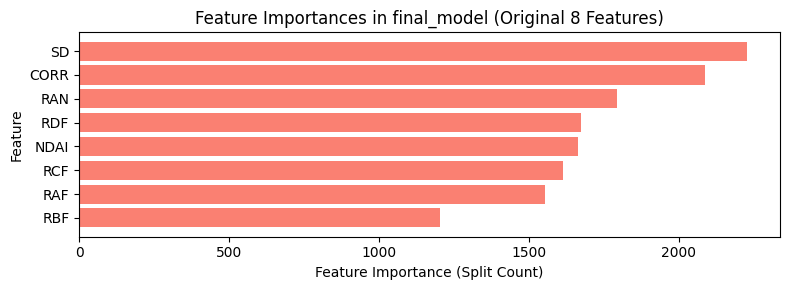

In [5]:
# Get feature importances from the XGBoost final_model
# Use "weight" as the importance type, which counts the number of splits using the feature.
importances_dict = final_model_1.get_score(importance_type="weight")

if hasattr(X_test, "columns"):
    feature_names = list(X_test.columns)
else:
    feature_names = [f"f{i}" for i in range(X_test.shape[1])]

# Build a list of (feature, importance) tuples.
feature_importance_pairs = []
for i, name in enumerate(feature_names):

    key = name if name in importances_dict else f"f{i}"
    importance_value = importances_dict.get(key, 0)
    feature_importance_pairs.append((name, importance_value))

# Sort features by importance (highest first)
feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print all features and their importance
print("Feature Importances for final_model (Original 8 Features):")
for name, imp in feature_importance_pairs:
    print(f"{name}: {imp}")

# Plot feature importances as a horizontal bar plot
features = [pair[0] for pair in feature_importance_pairs]
importances = [pair[1] for pair in feature_importance_pairs]

plt.figure(figsize=(8, 3))
plt.barh(features, importances, color='salmon')
plt.xlabel('Feature Importance (Split Count)')
plt.ylabel('Feature')
plt.title('Feature Importances in final_model (Original 8 Features)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


### Random Forest

In [7]:
# For consistency, map labels from {-1, 1} to {0, 1}
# (RandomForestClassifier will work with either, but for evaluation it’s often clearer to use {0,1})
y_df1_mod = np.where(np.array(y_df1) == -1, 0, y_df1)
y_df2_mod = np.where(np.array(y_df2) == -1, 0, y_df2)
y_train_full_mod = np.where(np.array(y_train_full) == -1, 0, y_train_full)
y_test_mod = np.where(np.array(y_test) == -1, 0, y_test)

In [8]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Define two folds:
# Fold 1: Train on df1, validate on df2
# Fold 2: Train on df2, validate on df1
folds = [
    (X_df1, y_df1_mod, X_df2, y_df2_mod),
    (X_df2, y_df2_mod, X_df1, y_df1_mod)
]

best_params = None
best_avg_val_error = float('inf')

In [9]:
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            params = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'random_state': 42
            }
            val_errors = []
            print(f"Testing: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}")
            for X_train, y_train, X_valid, y_valid in folds:
                model = RandomForestClassifier(**params)
                model.fit(X_train, y_train)
                y_pred_valid = model.predict(X_valid)
                # Compute error as 1 - accuracy
                error = 1 - accuracy_score(y_valid, y_pred_valid)
                val_errors.append(error)
            avg_val_error = np.mean(val_errors)
            print(f"Average Validation Error: {avg_val_error:.4f}")
            if avg_val_error < best_avg_val_error:
                best_avg_val_error = avg_val_error
                best_params = params

print(f"\nBest Parameters: {best_params}")
print(f"Best Average Validation Error: {best_avg_val_error:.4f}")

Testing: n_estimators=100, max_depth=None, min_samples_split=2
Average Validation Error: 0.2767
Testing: n_estimators=100, max_depth=None, min_samples_split=5
Average Validation Error: 0.2999
Testing: n_estimators=100, max_depth=10, min_samples_split=2
Average Validation Error: 0.2935
Testing: n_estimators=100, max_depth=10, min_samples_split=5
Average Validation Error: 0.3086
Testing: n_estimators=100, max_depth=20, min_samples_split=2
Average Validation Error: 0.3350
Testing: n_estimators=100, max_depth=20, min_samples_split=5
Average Validation Error: 0.3001
Testing: n_estimators=200, max_depth=None, min_samples_split=2
Average Validation Error: 0.3609
Testing: n_estimators=200, max_depth=None, min_samples_split=5
Average Validation Error: 0.3395
Testing: n_estimators=200, max_depth=10, min_samples_split=2
Average Validation Error: 0.2991
Testing: n_estimators=200, max_depth=10, min_samples_split=5
Average Validation Error: 0.3290
Testing: n_estimators=200, max_depth=20, min_samples

In [10]:
model_final = RandomForestClassifier(**best_params)
model_final.fit(X_train_full, y_train_full_mod)
y_pred_final = model_final.predict(X_test)
test_accuracy = accuracy_score(y_test_mod, y_pred_final)
test_error = 1 - test_accuracy
print(f"Test Error: {test_error:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Error: 0.0807
Test Accuracy: 0.9193


Feature Importances for final_model (Random Forest):
SD: 0.37323809936488767
NDAI: 0.19919445483053727
RDF: 0.10545625736462003
CORR: 0.09296731666728517
RAN: 0.0858062579066008
RAF: 0.05619118462752878
RBF: 0.04722891659982184
RCF: 0.03991751263871845


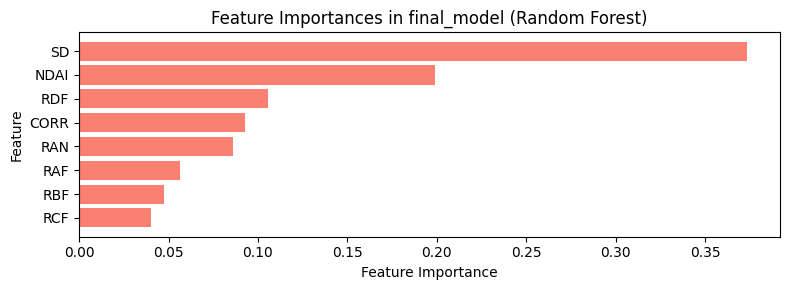

In [11]:
# Random Forest provides feature importances via the attribute feature_importances_
importances = model_final.feature_importances_
if hasattr(X_test, "columns"):
    feature_names = list(X_test.columns)
else:
    feature_names = [f"f{i}" for i in range(X_test.shape[1])]

# Create list of (feature, importance) tuples and sort descending
feature_importance_pairs = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("Feature Importances for final_model (Random Forest):")
for name, imp in feature_importance_pairs:
    print(f"{name}: {imp}")

# Plot feature importances as a horizontal bar plot
features = [pair[0] for pair in feature_importance_pairs]
importances_sorted = [pair[1] for pair in feature_importance_pairs]

plt.figure(figsize=(8, 3))
plt.barh(features, importances_sorted, color='salmon')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in final_model (Random Forest)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

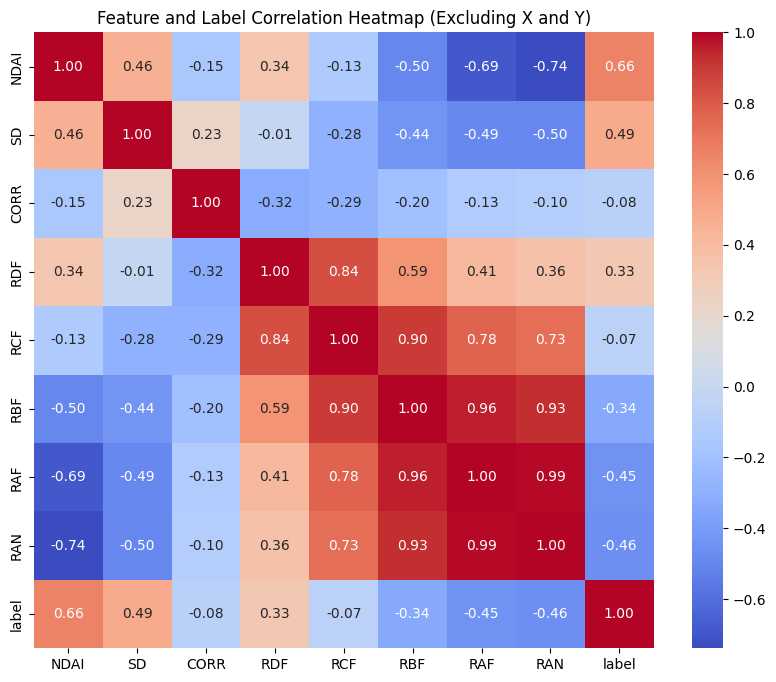

In [15]:
# Create a new DataFrame excluding X and Y
df_for_corr = df_train.drop(columns=['X', 'Y'])

# Compute correlation (
corr_matrix_full = df_for_corr.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_full, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature and Label Correlation Heatmap (Excluding X and Y)")
plt.show()


### Addition of features

In [16]:
def local_mean(arr):
    return np.nanmean(arr)

def local_std(arr):
    return np.nanstd(arr)

def add_local_features_2d(df, feature='NDAI'):
    """
    Pivot a single feature into 2D, apply 3x3 filter,
    then merge the result back to df as new columns.
    """
    # Pivot to 2D
    # Make sure your X, Y are integers or consistent enough to pivot
    pivoted = df.pivot_table(index='Y', columns='X', values=feature)
    pivoted = pivoted.sort_index(axis='index', ascending=False)  # e.g. top-to-bottom

    # applying generic_filter on the 2D array
    filtered_mean = generic_filter(pivoted.values, local_mean, size=3)
    filtered_std = generic_filter(pivoted.values, local_std, size=3)

    # put results into DataFrame with same shape
    pivoted_mean = pd.DataFrame(filtered_mean, index=pivoted.index, columns=pivoted.columns)
    pivoted_std = pd.DataFrame(filtered_std,  index=pivoted.index, columns=pivoted.columns)

    #  Melt (or stack) back to long format
    pivoted_mean_long = pivoted_mean.reset_index().melt(id_vars='Y', var_name='X', value_name=f'{feature}_mean')
    pivoted_std_long  = pivoted_std.reset_index().melt(id_vars='Y', var_name='X', value_name=f'{feature}_std')

    #Merge these new columns back to the original df
    df_merged = df.merge(pivoted_mean_long, on=['Y', 'X'], how='left')
    df_merged = df_merged.merge(pivoted_std_long, on=['Y', 'X'], how='left')
    return df_merged

# Example usage:
df1 = add_local_features_2d(df1, 'NDAI')
df1 = add_local_features_2d(df1, 'SD')
df1 = add_local_features_2d(df1, 'CORR')

df2 = add_local_features_2d(df2, 'NDAI')
df2 = add_local_features_2d(df2, 'SD')
df2 = add_local_features_2d(df2, 'CORR')

df3 = add_local_features_2d(df3, 'NDAI')
df3 = add_local_features_2d(df3, 'SD')
df3 = add_local_features_2d(df3, 'CORR')



C:\Users\hfoss\AppData\Local\Temp\ipykernel_49516\2513894288.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr)
c:\Users\hfoss\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hfoss\AppData\Local\Temp\ipykernel_49516\2513894288.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr)
c:\Users\hfoss\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hfoss\AppData\Local\Temp\ipykernel_49516\2513894288.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr)
c:\Users\hfoss\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=a

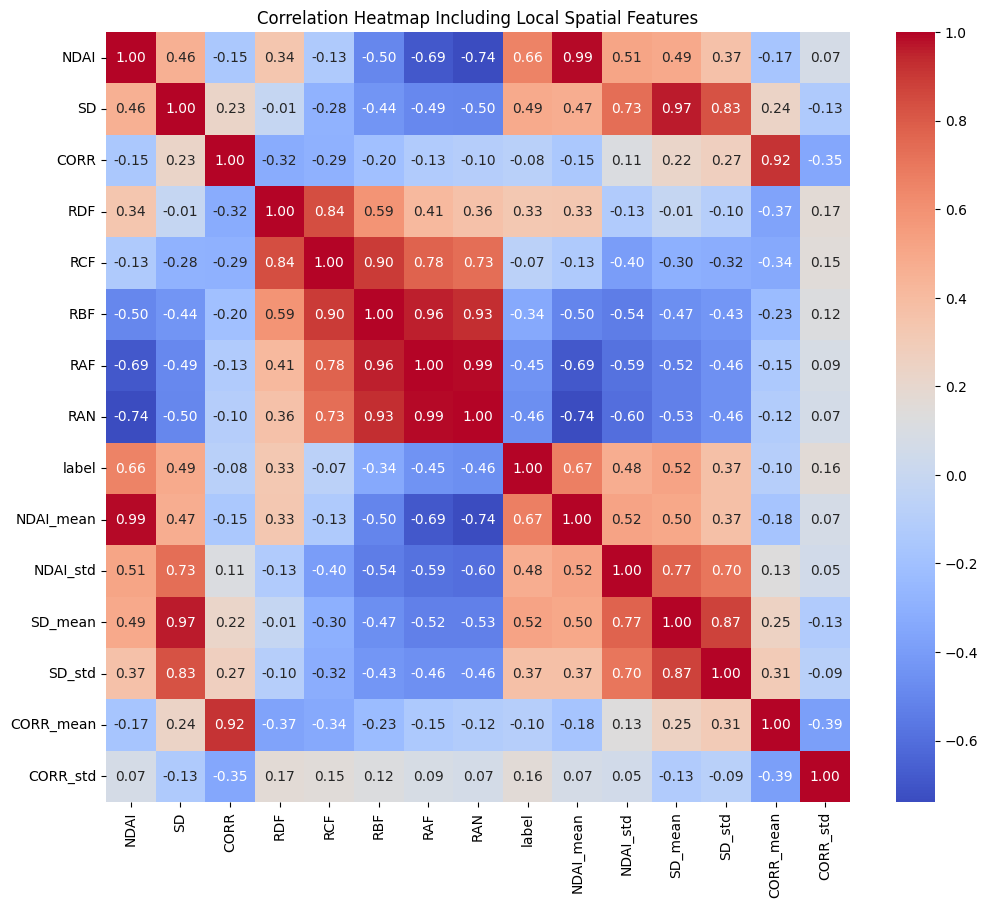

In [17]:

df_train_new = pd.concat([df1, df2])
# Drop the spatial coordinate columns, but keep the label and all feature columns (including local ones)
df_for_corr = df_train_new.drop(columns=['X', 'Y'])

plt.figure(figsize=(12, 10))
sns.heatmap(df_for_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap Including Local Spatial Features")
plt.show()
